In [7]:
import numpy as np
from sklearn import preprocessing
from numpy import random
import time
from sklearn import metrics

def tansig(x):
    return (2/(1+np.exp(-2*x)))-1

def pinv(A,reg):
    return np.mat(reg*np.eye(A.shape[1])+A.T.dot(A)).I.dot(A.T)


'''
参数压缩
'''
def shrinkage(a,b):
    z = np.maximum(a - b, 0) - np.maximum( -a - b, 0)
    return z
'''
参数稀疏化
'''
def sparse_bls(A,b):
    lam = 0.001
    itrs = 50
    AA = np.dot(A.T,A)   
    m = A.shape[1]
    n = b.shape[1]
    wk = np.zeros([m,n],dtype = 'double')
    ok = np.zeros([m,n],dtype = 'double')
    uk = np.zeros([m,n],dtype = 'double')
    L1 = np.mat(AA + np.eye(m)).I
    L2 = np.dot(np.dot(L1,A.T),b)
    for i in range(itrs):
        tempc = ok - uk
        ck =  L2 + np.dot(L1,tempc)
        ok = shrinkage(ck + uk, lam)
        uk += ck - ok
        wk = ok
    return wk
def bls_regression2(train_x,train_y,test_x,test_y,s,C,NumFea,NumWin,NumEnhan):
   
    u = 0
    WF = list()
    for i in range(NumWin):
        random.seed(i+u)
        WeightFea=2*random.randn(train_x.shape[1]+1,NumFea)-1;
        WF.append(WeightFea)
#    random.seed(100)
    WeightEnhan=2*random.randn(NumWin*NumFea+1,NumEnhan)-1;
    time_start = time.time()
    H1 = np.hstack([train_x, 0.1 * np.ones([train_x.shape[0],1])]);
    y = np.zeros([train_x.shape[0],NumWin*NumFea])
    WFSparse = list()
    distOfMaxAndMin = np.zeros(NumWin)
    meanOfEachWindow = np.zeros(NumWin)
    for i in range(NumWin):
        WeightFea = WF[i]
        A1 = H1.dot(WeightFea)        
        scaler1 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(A1)
        A1 = scaler1.transform(A1)
        WeightFeaSparse  = sparse_bls(A1,H1).T
        WFSparse.append(WeightFeaSparse)
    
        T1 = H1.dot(WeightFeaSparse)
        meanOfEachWindow[i] = T1.mean()
        distOfMaxAndMin[i] = T1.max() - T1.min()
        T1 = (T1 - meanOfEachWindow[i])/distOfMaxAndMin[i] 
        y[:,NumFea*i:NumFea*(i+1)] = T1

    H2 = np.hstack([y,0.1 * np.ones([y.shape[0],1])])
    T2 = H2.dot(WeightEnhan)
    T2 = tansig(T2);
    T3 = np.hstack([y,T2])
    WeightTop = pinv(T3,C).dot(train_y)

    Training_time = time.time()- time_start
    print('Training has been finished!');
    print('The Total Training Time is : ', round(Training_time,6), ' seconds' )
    NetoutTrain = T3.dot(WeightTop)

    RMSE = np.sqrt((NetoutTrain-train_y).T*(NetoutTrain-train_y)/train_y.shape[0]) #均方根误差
    MAPE = sum(abs(NetoutTrain-train_y))/train_y.mean()/train_y.shape[0]  #平均绝对百分比误差
    RR2=metrics.r2_score(NetoutTrain,train_y)#决定系数
    
    train_RMSE = RMSE
    train_MAPE = MAPE
    train_RR2=RR2
    
    print('Training RMSE is : ',RMSE);
    print('Training MAPE is : ', MAPE)
    print('Training RR2 is : ',RR2)
    
    time_start = time.time()
    HH1 = np.hstack([test_x, 0.1 * np.ones([test_x.shape[0],1])])
    yy1=np.zeros([test_x.shape[0],NumWin*NumFea])
    for i in range(NumWin):
        WeightFeaSparse = WFSparse[i]
        TT1 = HH1.dot(WeightFeaSparse)
        TT1  = (TT1 - meanOfEachWindow[i])/distOfMaxAndMin[i]   
        yy1[:,NumFea*i:NumFea*(i+1)] = TT1

    HH2 = np.hstack([yy1, 0.1 * np.ones([yy1.shape[0],1])])
    TT2 = tansig(HH2.dot( WeightEnhan));
    TT3 = np.hstack([yy1,TT2])
    NetoutTest = TT3.dot(WeightTop)
    RMSE = np.sqrt((NetoutTest-test_y).T*(NetoutTest-test_y)/test_y.shape[0]);
    MAPE = sum(abs(NetoutTest-test_y))/test_y.mean()/test_y.shape[0]
    RR2=metrics.r2_score(NetoutTest,test_y)
    
    test_RMSE = RMSE
    test_MAPE = MAPE
    test_RR2=RR2
    
#%% Calculate the testing accuracy
    Testing_time = time.time() - time_start
    print('Testing has been finished!');
    print('The Total Testing Time is : ', round(Testing_time,6), ' seconds' );
    print('Testing RMSE is : ', RMSE) 
    print('Testing MAPE is : ', MAPE)
    print('Testing RR2 is : ',RR2)
    return test_RMSE,test_MAPE,test_RR2,Testing_time,train_RMSE,train_MAPE,train_RR2,Training_time,NetoutTest,test_y



In [4]:
#导入train-x,train-y,test-x,test-y
import pandas as pd
import numpy as np
train=pd.read_csv(r'C:\Users\ZHUO\Desktop\train_fsMIR_scaler.csv',index_col=0)
test=pd.read_csv(r'C:\Users\ZHUO\Desktop\test_fsMIR_scaler.csv',index_col=0)


#train.shape #3182,177
#test.shape #1365,177

train_x=np.double(train.drop(columns=['heart_rate_change_value'],axis=1))
train_y=np.double(train['heart_rate_change_value']).reshape(-1,1)
test_x=np.double(test.drop(columns=['heart_rate_change_value'],axis=1))
test_y=np.double(test['heart_rate_change_value']).reshape(-1,1)

Training has been finished!
The Total Training Time is :  0.241522  seconds
Training RMSE is :  [[0.00131193]]
Training MAPE is :  [[0.00247546]]
Training RR2 is :  0.9998704267398774
Testing has been finished!
The Total Testing Time is :  0.025552  seconds
Testing RMSE is :  [[0.00132003]]
Testing MAPE is :  [[0.00245334]]
Testing RR2 is :  0.9998692732867904
1365


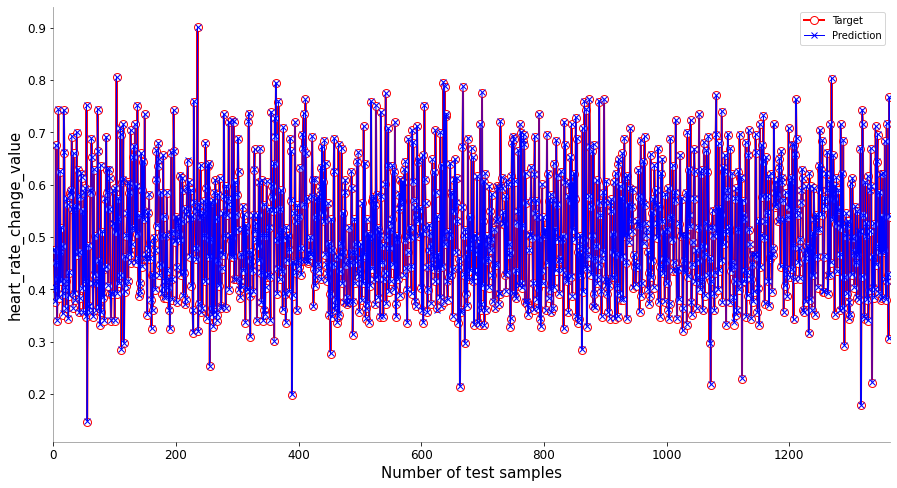

In [32]:
import matplotlib.pyplot as plt

# 作图 
# 18 13 198  20 33 200
#18 14 23
NumFea = 18
NumWin = 14
NumEnhan = 23
s = 0.8
C = 2**-30

## 绘制预测曲线
test_RMSE,test_MAPE,test_RR2,Testing_time,train_RMSE,train_MAPE,train_RR2,Training_time,NetoutTest,test_y= bls_regression2(train_x,train_y,test_x,test_y,s,C,NumFea,NumWin,NumEnhan)
print(len(NetoutTest))


plt.figure(figsize = (15,8))
# colors = ["#348ABD", "#A60628", "#7A68A6"]
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
x1 = range(len(NetoutTest))
plt.plot(test_y,linewidth=2,marker='o',markerfacecolor='white',c='red',markersize = 8)
plt.plot(NetoutTest,'blue',linewidth=1,marker='x')

# plt.plot(1/Curve2,'indianred',linewidth=3)
# plt.scatter(x1,1/Curve1, cmap = cmap,s = 50);
ax=plt.gca()  #gca:get current axis得到当前轴
#设置图片的右边框和上边框为不显示
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_alpha(0.4)
ax.spines['bottom'].set_alpha(0.4)

plt.xlabel('Number of test samples',fontsize = 15)
plt.xlim(0,len(NetoutTest))
plt.ylabel("heart_rate_change_value",fontsize=15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.ylim(-3,10)
# plt.grid()
# plt.title('SSA-BLS',fontsize='large')
plt.legend(['Target','Prediction'], loc='upper right')
# plt.savefig('./figures/IGWOIter.png')
plt.show()






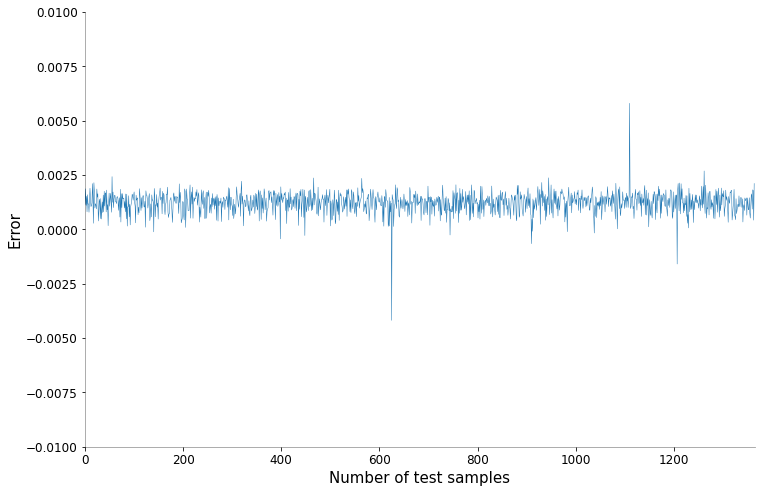

In [30]:
## 误差曲线1 误差曲线
Curve5 = np.zeros(len(NetoutTest))
for i in range(len(NetoutTest)):
    Curve5[i] = (NetoutTest[i]-test_y[i])

plt.figure(figsize = (12,8))
# colors = ["#348ABD", "#A60628", "#7A68A6"]
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
x1 = range(len(NetoutTest))
plt.plot(Curve5,linewidth=0.5,marker='None',markerfacecolor='white')

ax=plt.gca()  #gca:get current axis得到当前轴
#设置图片的右边框和上边框为不显示
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_alpha(0.4)
ax.spines['bottom'].set_alpha(0.4)

plt.xlabel('Number of test samples',fontsize=15)
plt.xlim(0,len(NetoutTest))
plt.ylabel("Error",fontsize=15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.ylim(-5.5,5)
plt.ylim(-0.01,0.01)
# plt.ylim(Curve.min(),Curve.max())
# plt.grid()
# plt.title('SSA-BLS',fontsize='large')
# plt.legend(['Average fitness','Best fitness'], loc='upper right',fontsize = 'large')
# plt.savefig('./figures/IGWOIter.png')
plt.show()


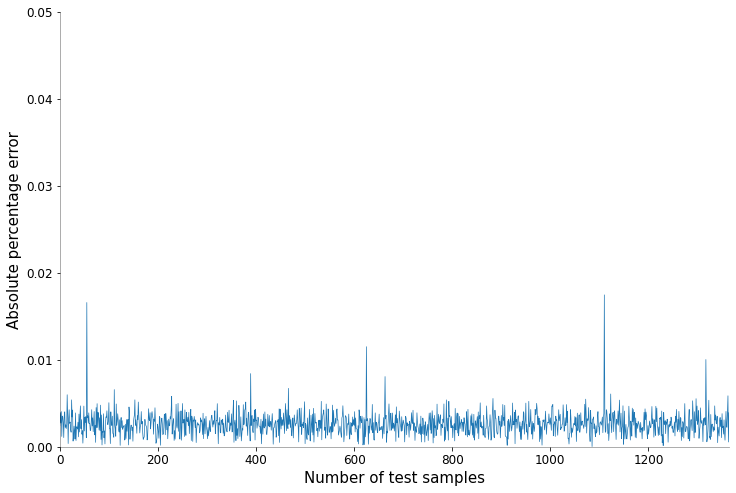

In [27]:
import numpy as np
import matplotlib.pyplot as plt
## 误差曲线2 绝对百分比误差曲线
Curve6 = np.zeros(len(NetoutTest))
for i in range(len(NetoutTest)):
    Curve6[i] = abs((NetoutTest[i]-test_y[i])/test_y[i])

plt.figure(figsize = (12,8))
# colors = ["#348ABD", "#A60628", "#7A68A6"]
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
x1 = range(len(NetoutTest))
plt.plot(Curve6,linewidth=0.7,marker='None',markerfacecolor='white')
# plt.plot(test_yout,'cornflowerblue',linewidth=1,marker='x')

# plt.plot(1/Curve2,'indianred',linewidth=3)
# plt.scatter(x1,1/Curve1, cmap = cmap,s = 50);
ax=plt.gca()  #gca:get current axis得到当前轴
#设置图片的右边框和上边框为不显示
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_alpha(0.4)
ax.spines['bottom'].set_alpha(0.4)

plt.xlabel('Number of test samples',fontsize=15)
plt.xlim(0,len(NetoutTest))
plt.ylabel("Absolute percentage error",fontsize=15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0,0.05)
# plt.ylim(Curve.min(),Curve.max())
# plt.grid()
# plt.title('SSA-BLS',fontsize='large')
# plt.legend(['Average fitness','Best fitness'], loc='upper right',fontsize = 'large')
# plt.savefig('./figures/IGWOIter.png')
plt.show()
